# Autocorrelation Functions and Fourier Transforms with Libra

## Table of Content <a name="TOC"></a>

1. [General setups](#1)

2. [Computing ACF](#2) 

  2.1. [Using a list of vectors](#2.1) 
  
  2.2. [Using a list of MATRIX objects](#2.2)   
  
3. [Computing spectra](#3)


### A. Learning objectives

- to compute autocorrelation function (ACF) of provided data
- to know two conventions used to compute the ACF
- to compute the Fourier Transform (FT) of the ACF
- to plot spectra computed as FT of the ACF
- to know the unit conversions used in the spectra calculations 


### B. Use cases

- compute ACF of data series
- compute spectra


### C. Functions

- `libra_py`
  - `acf`
    - [`acf_mat`](#acf_mat-1) | [also here](#acf_mat-2)
    - [`acf_vec`](#acf_vec-1) | [also here](#acf_vec-2)
  - `ft`
    - [`ft2`](#ft2-1) | [also here](#ft2-1)
  - `units`
    - [`au2wavn`](#au2wavn-1) 
    - [`fs2au`](#fs2au-1)
    - [`inv_cm2Ha`](#inv_cm2Ha-1)


### D. Classes and class members

None


## 1. General setups
<a name="1"></a> [Back to TOC](#TOC)

In [1]:
import math, sys, cmath, os
import numpy as np

from liblibra_core import *

import util.libutil as comn
from libra_py import units, acf, ft
import matplotlib.pyplot as plt   # plots
#matplotlib.use('Agg')
#%matplotlib inline 

#from matplotlib.mlab import griddata

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vect

## 2. Computing ACF
<a name="2"></a>[Back to TOC](#TOC)

### 2.1. Using a list of vectors
<a name="2.1"></a>[Back to TOC](#TOC)

This a very specific example - we use a list of vectors representing coordinates of a single point in a 3D space: (x, y, z).
<a name="inv_cm2Ha-1"></a><a name="fs2au-1"></a>

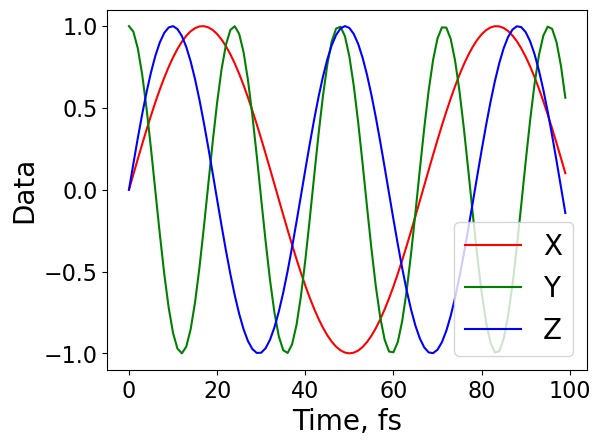

In [2]:
# Generate data with  3 frequences
# initial frequencies are in atomic units, but given in the cm^-1 
# for convenience
w1 = 500.0 * units.inv_cm2Ha
w2 = 1400.0 * units.inv_cm2Ha
w3 = 850.0 * units.inv_cm2Ha

# Now generate the data series - it is x,y,z vector, each component 
# evolves with its own frequency - assume each data point is distanced
# from the previous one by time dt
data, datax, datay, dataz, T = [], [], [], [], []
dt = 1.0 # time in fs

for it in range(1000):
    t = it * dt * units.fs2au  # time and frequencies should be in comparable units
    x, y, z = math.sin(w1*t), math.cos(w2*t), math.sin(w3*t)
    data.append( VECTOR(x, y, z) )
    T.append(it*dt) # in fs
    datax.append(x)
    datay.append(y)
    dataz.append(z)

# Plot the data 
plt.xlabel("Time, fs")
plt.ylabel("Data")
plt.plot(T[:100], datax[:100], label="X", c="red")
plt.plot(T[:100], datay[:100], label="Y", c="green")
plt.plot(T[:100], dataz[:100], label="Z", c="blue")
plt.legend()

To compute the ACF, we use the following function:
<a name="acf_vec-1"></a>

In [3]:
help(acf.acf_vec)

Help on function acf_vec in module libra_py.acf:

acf_vec(data, dt, opt=0)
    Compute the autocorrelation function of the given data set
    
    Args:
        data ( list of VECTOR objects ): sequence of real-valued 3-dimensional vectors
        dt ( double ): time distance between the adjacent data points [units: general]
        opt ( int ): selector of the convention to to compute ACF
    
            * 0 : the chemist convention,  (1/(N-h)) Sum_{t=1,N-h} (Y[t]*Y[t+h])
            * 1 : the statistician convention, (1/N) Sum_{t=1,N-h} (Y[t]*Y[t+h])
    
    Returns:
        tuple: (T, nautocorr, autocorr), where:
    
            T (list of sz doubles ): lag time scale for the ACF [units: same as for dt]
            nautocorr (list of sz doubles ): normalized ACF
            autocorr (list of sz doubles ): un-normalized ACF
    
    SeeAlso:
        https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm



The ACF is computed as:

$C(i) = \frac{1}{Norm_i} \sum_{j=0}^{j=N-1-i} X[j]^T X[j + i]$

Here, the upper limit of summation is chosen such that the combined index `j+i` doesn't exceed the range of the original data indices

As explained in the help docstring above, there are two ways of computing ACF of N-data points:

* `opt = 0` is what we call a "chemists" convention, in this case: $Norm_i$ is the actual number of terms in the summation for a given lag index $i$, multiplied by the dimensionality of data points, $Norm_i = (N-1-i) \times ndof$. With this convention, the larger the lag index, the fewer points is used to compute the ACF. In this regard, the ACF becomes increasingly poorer converged. In fact, it isn't guaranteed to decay to zero, and its integral may be divergent. It may be more reasonable to use only the first half of the ACF computed this way. 

* `opt = 1` is what we call the "statistitians'" convention, in this case: $Norm_i$ is the total number of the data points in series, multiplied by the data dimensionality, $Norm_i = N-1 \times ndof$ In this case, the ACF is artifically dampened for larger lag values, even though there would be a decreasing number of points to compute the numerator. In this way, the ACF is more biased, but has desirable properties - converges to zero for infinite lags, and its integral may be convergent. 

Below is a snippet of the key component of the code to compute such ACFs:

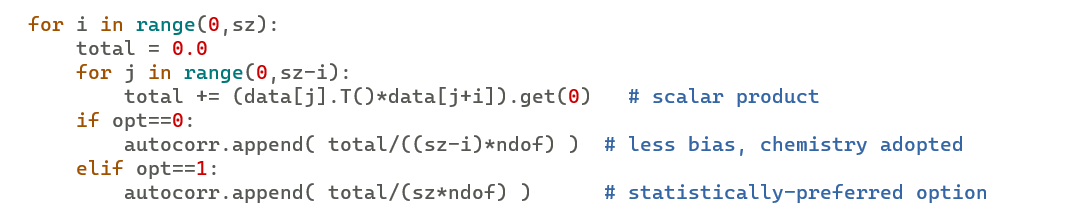
<a name="acf_vec-2"></a>

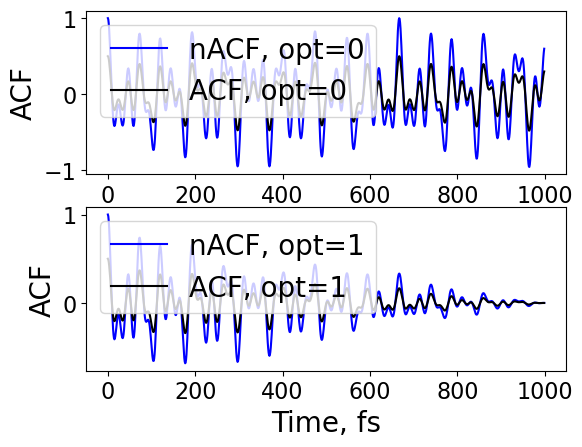

In [4]:
# Now, let's compute the ACF
T, nACF0, ACF0 = acf.acf_vec(data, dt, opt=0)
T, nACF1, ACF1 = acf.acf_vec(data, dt, opt=1)

plt.subplot(2,1, 1)
plt.plot(T, nACF0, label="nACF, opt=0", c="blue")
plt.plot(T, ACF0, label="ACF, opt=0", c="black")
plt.ylabel("ACF")
plt.legend()

plt.subplot(2,1, 2)
plt.plot(T, nACF1, label="nACF, opt=1", c="blue")
plt.plot(T, ACF1, label="ACF, opt=1", c="black")
plt.xlabel("Time, fs")
plt.ylabel("ACF")
plt.legend()


### 2.2. Using a list of MATRIX objects
<a name="2.2"></a>[Back to TOC](#TOC)

We can collect data as a list of Ndof x 1 matrices. In comparison to the list of VECTOR objects, it is a more general procedure since it allows using vectors of arbitrary dimension. For instance, these could be 3N-6 dimesional vectors representing internal coordinates of the N-atomic system.

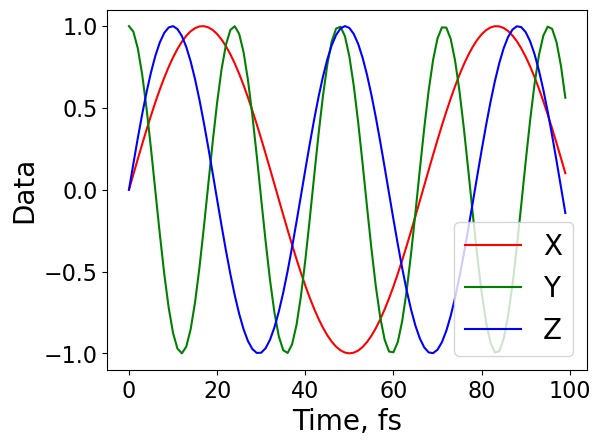

In [5]:
# Generate data with  3 frequences
# initial frequencies are in atomic units, but given in the cm^-1 
# for convenience
w1 = 500.0 * units.inv_cm2Ha
w2 = 1400.0 * units.inv_cm2Ha
w3 = 850.0 * units.inv_cm2Ha

# Now generate the data series - it is x,y,z vector, each component 
# evolves with its own frequency - assume each data point is distanced
# from the previous one by time dt
data, datax, datay, dataz, T = [], [], [], [], []
dt = 1.0 # time in fs

for it in range(1000):
    t = it * dt * units.fs2au  # time and frequencies should be in comparable units
    x, y, z = math.sin(w1*t), math.cos(w2*t), math.sin(w3*t)
    d = MATRIX(3,1)
    d.set(0,0, x)
    d.set(1,0, y)
    d.set(2,0, z)
    data.append( d )
    T.append(it*dt) # in fs
    datax.append(x)
    datay.append(y)
    dataz.append(z)

# Plot the data 
plt.xlabel("Time, fs")
plt.ylabel("Data")
plt.plot(T[:100], datax[:100], label="X", c="red")
plt.plot(T[:100], datay[:100], label="Y", c="green")
plt.plot(T[:100], dataz[:100], label="Z", c="blue")
plt.legend()

To compute the ACF of such data series, we use the following function:
<a name="acf_mat-1"></a>

In [6]:
help(acf.acf_mat)

Help on function acf_mat in module libra_py.acf:

acf_mat(data, dt, opt=0)
    Compute the autocorrelation function of the given data set
    
    Args:
        data ( list of MATRIX(ndof, 1) objects ): sequence of real-valued ndof-dimensional vectors
        dt ( double ): time distance between the adjacent data points [units: general]
        opt ( int ): selector of the convention to to compute ACF
    
            * 0 : the chemist convention,  (1/(N-h)) Sum_{t=1,N-h} (Y[t]*Y[t+h])
            * 1 : the statistician convention, (1/N) Sum_{t=1,N-h} (Y[t]*Y[t+h])
    
    Returns:
        tuple: (T, nautocorr, autocorr), where:
    
            T (list of sz doubles ): lag time scale for the ACF [units: same as for dt]
            nautocorr (list of sz doubles ): normalized ACF
            autocorr (list of sz doubles ): un-normalized ACF
    
    SeeAlso:
        https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm



<a name="acf_mat-2"></a>

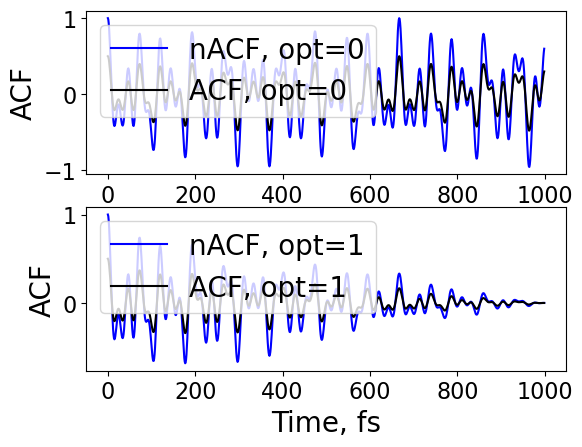

In [7]:
# Now, let's compute the ACF
T, nACF0, ACF0 = acf.acf_mat(data, dt, opt=0)
T, nACF1, ACF1 = acf.acf_mat(data, dt, opt=1)

plt.subplot(2,1, 1)
plt.plot(T, nACF0, label="nACF, opt=0", c="blue")
plt.plot(T, ACF0, label="ACF, opt=0", c="black")
#plt.xlabel("Time, fs")
plt.ylabel("ACF")
plt.legend()

plt.subplot(2,1, 2)
plt.plot(T, nACF1, label="nACF, opt=1", c="blue")
plt.plot(T, ACF1, label="ACF, opt=1", c="black")
plt.xlabel("Time, fs")
plt.ylabel("ACF")
plt.legend()


## 3. Computing spectra
<a name="3"></a>[Back to TOC](#TOC)

Now, let's compute the FT of the ACFs. At this point, it doesn't matter what way of computing the ACF we choose (both give the same results). In practice, we basically use the latest calculations in the rest of the notebook.

The Fourier Transform (FT) of the ACF yield the desired spectrum. To compute it, we use the following function:
<a name="ft2-1"></a>

In [8]:
help(ft.ft2)

Help on function ft2 in module libra_py.ft:

ft2(X, wmin, wmax, dw, dt)
    Discrete Fourier transform
    
    We do have a number of FT and FFT functions in the Libra core, but
    this one may be also convenient to have
    
    Args:
        X ( list of floats ): data time-series
        wmin ( float ): the minimal value of frequencies we want to compute
        wmax ( float ): the minimal value of frequencies we want to compute
        dw ( float ): is the distance between the nearby points on the frequency scale
        dt ( float ): is the time step
    
    Returns: 
        tuple: (W, J): where
    
            W ( list of npoints doubles): frequencies               
            J ( list of npoints complex): amplitudes of the complex-transform, J
            I ( list of npoints doubles): intensities, I = |J|
            I2 ( list of npoints doubles): squared intensities, I^2 = |J|^2
            J_re (list of npoints doubles): real components of J coefficients
            J_im 

To get the reasonable spectrum, we have to use consistent units of time and frequency. Here, we use the atomic units.

For frequency, the conversion from the commonly used $cm^{-1}$ to atomic units is done with `units.inv_cm2Ha`

For timestep, we assume the data points are separated by 1 fs (this is the assumption from the data generation step). To convert it to the atomic units, we use: `units.fs2au` conversion factor.

The `ft.ft2` function returns frequency axis for convenient plotting of spectra, but we need to convert it back to $cm^{-1}$. This is done with `units.au2wavn`

Here, we compare several ways of computing spectra - using normalized (e.g. In0 and In1) or unnormalized (I0 and I1) ACFs. The difference between 0 and 1 is the convention used to compute ACF. 
<a name="ft2-2"></a><a name="au2wavn-1"></a>

In [9]:
dw = 1.0 * units.inv_cm2Ha # 
dt = 1.0 * units.fs2au
wmin =    0.0 * units.inv_cm2Ha
wmax = 2000.0 * units.inv_cm2Ha

W, _, _, In0, _, _ = ft.ft2(nACF0, wmin, wmax, dw, dt)
W, _, _, I0, _, _ = ft.ft2(ACF0, wmin, wmax, dw, dt)

W, _, _, In1, _, _ = ft.ft2(nACF1, wmin, wmax, dw, dt)
W, _, _, I1, _, _ = ft.ft2(ACF1, wmin, wmax, dw, dt)

W = np.array(W) * units.au2wavn

Finally, we can plot the spectra:

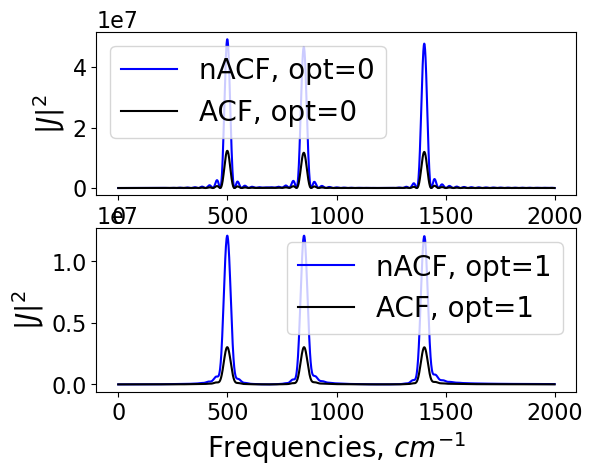

In [10]:
plt.subplot(2,1, 1)
plt.plot(W, In0, label="nACF, opt=0", c="blue")
plt.plot(W, I0, label="ACF, opt=0", c="black")
plt.ylabel("$|J|^2$")
plt.legend()

plt.subplot(2,1, 2)
plt.plot(W, In1, label="nACF, opt=1", c="blue")
plt.plot(W, I1, label="ACF, opt=1", c="black")
plt.xlabel("Frequencies, $cm^{-1}$")
plt.ylabel("$|J|^2$")
plt.legend()

As one can see, the statistical convention on ACFs (`opt = 1`) yields cleaner spectra, with a fewer secondary (artificial) peaks. The difference between normalized or unnormalized ACFs is that the normalized yield higher peak intencities